In [6]:
import sys
sys.path.append("./../../src")
from visualizer_helper import Visualizer
from cluster_helper import ClusterProcessor

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.sparse import csr_matrix
import scipy
import pickle
import os
from annoy import AnnoyIndex
from scipy.sparse.linalg import inv

from collections import Counter
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
cluster_assignments = pd.read_csv("./data/CLUSTER_ASSIGNMENTS.csv")
icd9codes = pd.read_csv("../../data/PATIENT_ICD_ICD9_CODES.csv")
patient_icd_binary = pickle.load(open("../../data/PATIENT_ICD_BINARY_SPARSE_CSR.p", 'rb'))
icd9diag = pd.read_csv("../../../mimic/D_ICD_DIAGNOSES.csv.gz")
icd9proc = pd.read_csv("../../../mimic/D_ICD_PROCEDURES.csv.gz")
k_neighbors = 100

In [3]:
clusters, counts = np.unique(cluster_assignments["CLUSTER"], return_counts=True)
clusters_by_size = sorted(list(zip(clusters, counts)), key=lambda p: p[1], reverse=True)

In [7]:
cp = ClusterProcessor(patient_icd_binary, icd9codes, icd9diag, cluster_assignments, k_neighbors,
                        other_stopwords = ["hypertension", 'disorder'])

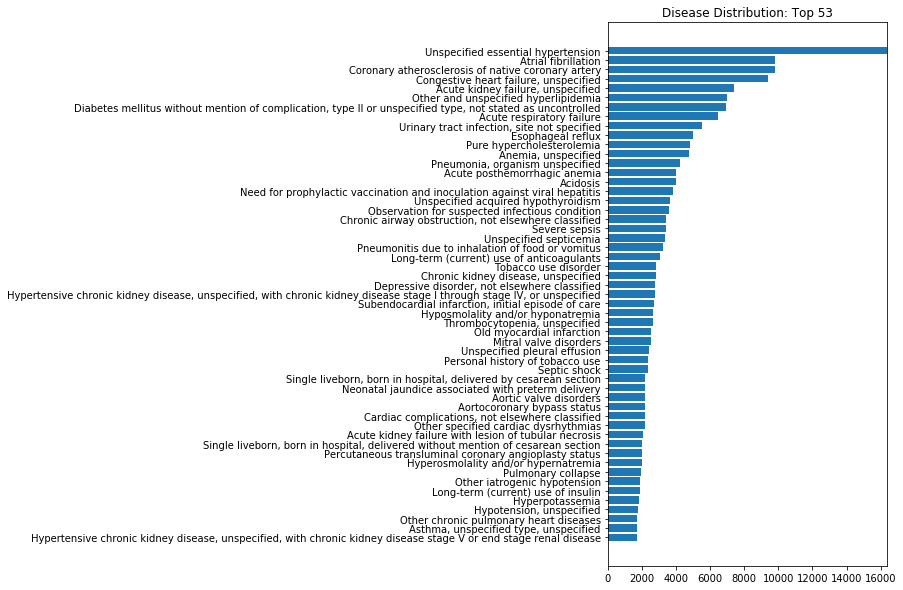

[('4019', 'Unspecified essential hypertension', 16361), ('42731', 'Atrial fibrillation', 9803), ('41401', 'Coronary atherosclerosis of native coronary artery', 9786), ('4280', 'Congestive heart failure, unspecified', 9405), ('5849', 'Acute kidney failure, unspecified', 7397), ('2724', 'Other and unspecified hyperlipidemia', 7016), ('25000', 'Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled', 6921), ('51881', 'Acute respiratory failure', 6479), ('5990', 'Urinary tract infection, site not specified', 5538), ('53081', 'Esophageal reflux', 4971), ('2720', 'Pure hypercholesterolemia', 4796), ('2859', 'Anemia, unspecified', 4768), ('486', 'Pneumonia, organism unspecified', 4256), ('2851', 'Acute posthemorrhagic anemia', 4012), ('2762', 'Acidosis', 4005), ('V053', 'Need for prophylactic vaccination and inoculation against viral hepatitis', 3835), ('2449', 'Unspecified acquired hypothyroidism', 3633), ('V290', 'Observation for suspected

In [9]:
print(cp.plot_disease_distribution(53))

1450


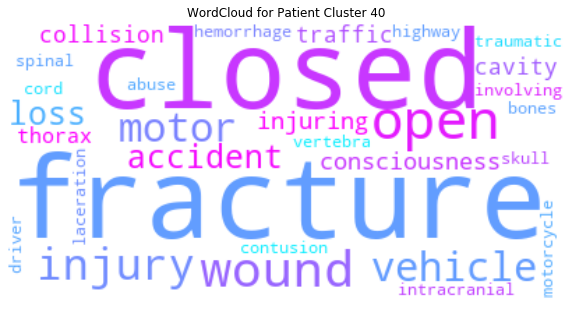

Counter({'fracture': 3242, 'closed': 3055, 'open': 2830, 'wound': 2504, 'injury': 1813, 'vehicle': 1586, 'motor': 1542, 'loss': 919, 'accident': 896, 'consciousness': 887, 'injuring': 862, 'traffic': 759, 'collision': 738, 'cavity': 696, 'thorax': 636, 'hemorrhage': 617, 'involving': 581, 'contusion': 556, 'intracranial': 528, 'motorcycle': 514, 'cord': 478, 'spinal': 476, 'vertebra': 467, 'traumatic': 465, 'abuse': 443, 'bones': 427, 'skull': 413, 'highway': 411, 'laceration': 396, 'driver': 386, 'alcohol': 364, 'subarachnoid': 359, 'subdural': 341, 'fall': 321, 'base': 313, 'lung': 304, 'following': 303, 'ribs': 301, 'one': 300, 'pedestrian': 257, 'duration': 252, 'scalp': 249, 'part': 247, 'pneumothorax': 247, 'extradural': 241, 'accidental': 240, 'level': 222, 'cervical': 211, 'accidents': 208, 'control': 207, 'multiple': 205, 'intra': 204, 'cerebral': 200, 'except': 197, 'liver': 193, 'infection': 189, 'neck': 186, 'state': 181, 'anemia': 180, 'end': 173, 'site': 172, 'shaft': 171

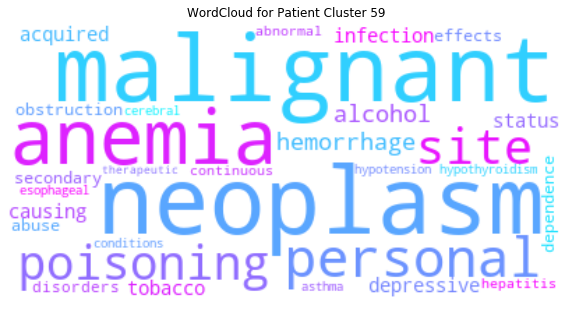

Counter({'neoplasm': 461, 'malignant': 453, 'anemia': 429, 'personal': 345, 'site': 278, 'poisoning': 278, 'hemorrhage': 274, 'alcohol': 273, 'depressive': 253, 'infection': 237, 'acquired': 230, 'causing': 227, 'tobacco': 224, 'status': 220, 'secondary': 209, 'obstruction': 207, 'dependence': 201, 'abuse': 195, 'effects': 192, 'disorders': 189, 'hepatitis': 181, 'continuous': 180, 'abnormal': 178, 'hypothyroidism': 174, 'asthma': 173, 'esophageal': 167, 'conditions': 162, 'cerebral': 156, 'hypotension': 154, 'therapeutic': 150, 'reflux': 150, 'adverse': 149, 'reaction': 149, 'urinary': 147, 'tract': 146, 'pulmonary': 142, 'hepatic': 140, 'operation': 139, 'coma': 138, 'cardiac': 138, 'epilepsy': 134, 'diabetes': 131, 'open': 129, 'pneumonia': 127, 'state': 127, 'injury': 126, 'fracture': 125, 'procedure': 124, 'drug': 118, 'wound': 118, 'withdrawal': 118, 'anxiety': 116, 'liver': 114, 'accidental': 114, 'pain': 114, 'current': 111, 'patient': 110, 'inflicted': 109, 'uncontrolled': 109

In [10]:
for c, size in clusters_by_size[:2]:
    print(size)
    print(cp.get_cluster_wordcloud(c))

In [ ]:
# def plot_icd_distribution(topk):

remaining_patient_idxs = cluster_assignments["ORIGINAL_INDEX"].values
remaining_patient_icd_binary = patient_icd_binary[remaining_patient_idxs]

patient_as_icd_codes = []
patient_as_titles = []

for i in tqdm(range(remaining_patient_icd_binary.shape[0])):
    patient_icd_idx = np.nonzero(remaining_patient_icd_binary[i])[1]

    patient_icd_codes = icd9codes.iloc[patient_icd_idx].values.flatten()
    patient_icd_codes_str = " ".join(patient_icd_codes)
    patient_as_icd_codes.append(patient_icd_codes_str)

    patient_titles = icd9diag[icd9diag["ICD9_CODE"].isin(patient_icd_codes)]["LONG_TITLE"].values.tolist()
    patient_titles_str = " ".join(patient_titles).lower()
    patient_as_titles.append(patient_titles_str)
    

In [ ]:
icd_tfidf = TfidfVectorizer().fit(patient_as_icd_codes)
title_tfidf = TfidfVectorizer().fit(patient_as_titles)

icd_count = CountVectorizer().fit(patient_as_icd_codes)
title_count = CountVectorizer().fit(patient_as_titles)